In [1]:
from JupyterImport import *
from plotly.subplots import make_subplots
import progressbar
from sys import stdout
root_logger.setLevel(logging.WARNING)

In [7]:
# dats = get_dats(range(540, 704+1), progress=True)  # 10x higher Channel bias than I should have applied
# dats = get_dats(range(705, 899+1), progress=True)  # Correct channel bias with HQPC at 1/2 plateau
dats = get_dats(range(965, 979+1), progress=True)  # With HQPC in first Plateau

N/A% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--D:\OneDrive\UBC LAB\GitHub\Python\PyDatAnalysis\src\DatObject\Attributes\DatAttribute.py:168: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

100% (15 of 15) |########################| Elapsed Time: 0:00:27 Time:  0:00:27


In [10]:
for dat in dats[14::15]:
#     print(abs(round(dat.Logs.fds['TC/0.001']/dat.Logs.fds['R2T(10M)']*-3, 1)))
    print(dat.Logs.comments)

N/A% (0 of 165) |                        | Elapsed Time: 0:03:35 ETA:  --:--:--

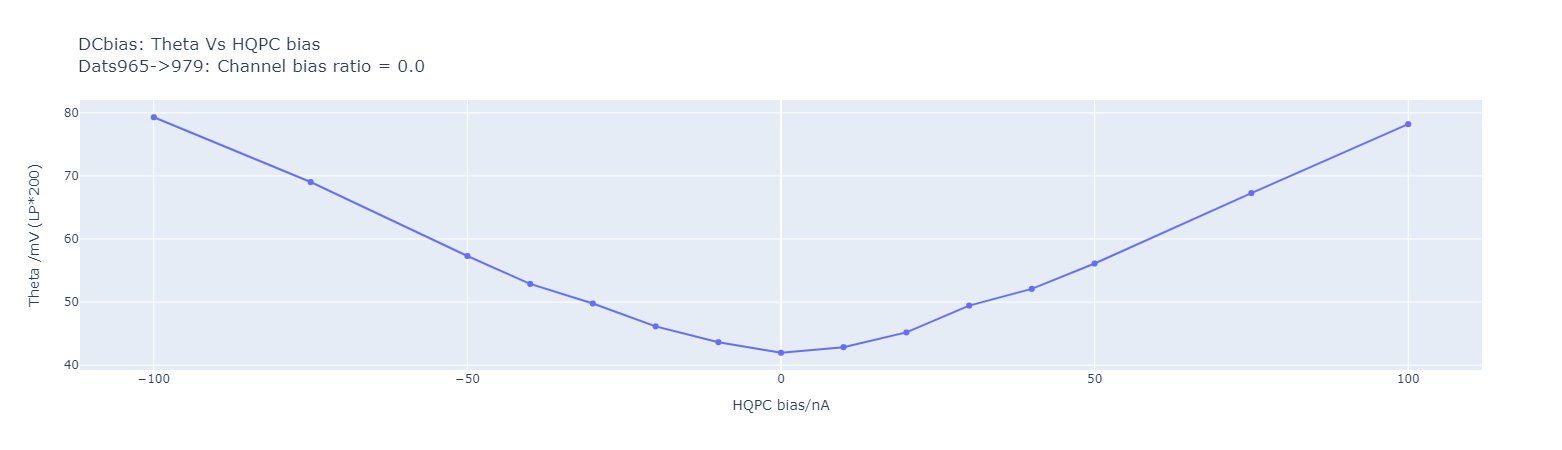

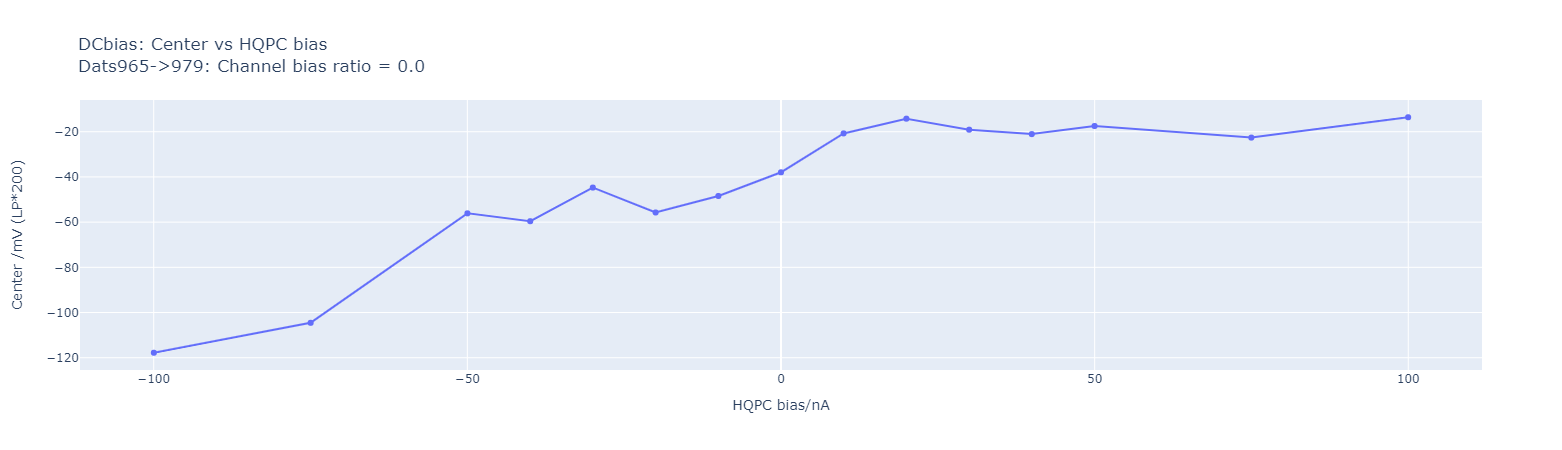

In [8]:
# data_key = 'theta'
# ylabel = 'Theta /mV (LP*200)'
hqpc_biases = set([round(dat.Logs.fds['R2T(10M)']) for dat in dats])

for data_key, ylabel, title, fname in zip(['theta', 'mid'], ['Theta /mV (LP*200)', 'Center /mV (LP*200)'], ['DCbias: Theta Vs HQPC bias', 'DCbias: Center vs HQPC bias'], ['ThetaVsHPQC', 'CenterVsHQPC']):
    dat_chunks = np.flip(np.reshape(np.array(dats), (int(len(dats)/len(hqpc_biases)), -1)), axis=0)

    xs, datas, ids, titles = list(), list(), list(), list()
    # for ratio in ratios:
    for dat_chunk in dat_chunks:
    #     ds = [dat for dat in dats if round(dat.Logs.fds['TC/0.001']/dat.Logs.fds['R2T(10M)'], 2) == ratio]
        ds = dat_chunk

        ratio = round(np.mean([-1*dat.Logs.fds['TC/0.001']/dat.Logs.fds['R2T(10M)'] if not np.isclose(dat.Logs.fds['R2T(10M)'],0) else 0 for dat in ds]), 4)

        datas.append(np.array([getattr(dat.Transition.avg_fit.best_values, data_key) for dat in ds]))
        xs.append(np.array([dat.Logs.fds['R2T(10M)']/10 for dat in ds]))
        ids.append(ratio)
        titles.append(f'{title}<br>Dats{ds[0].datnum}->{ds[-1].datnum}: Channel bias ratio = {ratio}')

    fig = PlU.get_figure(datas, xs, ids=ids, titles=titles, labels=None, xlabel='HQPC bias/nA', ylabel=ylabel, plot_kwargs={'mode':'lines+markers'})
#     fig.write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum}{fname}.html')
    fig.show()

<ipython-input-12-69af9adb5453>:21: RuntimeWarning:

divide by zero encountered in double_scalars



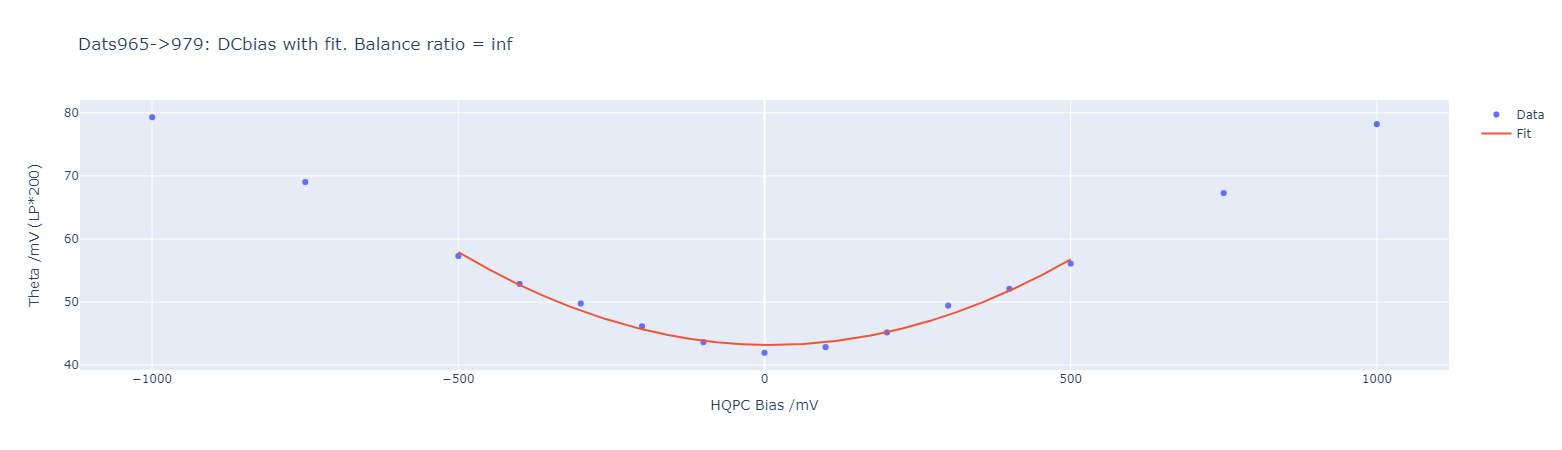

In [12]:
# dats = get_dats(range(735, 749+1))  # Best of Correct Channel biases and HQPC at half first plateau
dats = get_dats(range(965, 979+1))  # HQPC in 1st plateau


thetas = [dat.Transition.avg_fit.best_values.theta for dat in dats]
bias = [dat.Logs.fds['R2T(10M)'] for dat in dats]

idxs = CU.get_data_index(bias, [500, -500])

quad = lm.models.QuadraticModel()
pars = quad.make_params()
pars['b'].value = 0
pars['b'].vary = True
ftheta = thetas[idxs[0]:idxs[1]+1]
fbias= bias[idxs[0]:idxs[1]+1]
fit = quad.fit(ftheta, x=fbias, params=pars)

fig = go.Figure()
fig.add_trace(go.Scatter(x=bias, y=thetas, name='Data', mode='markers'))
x = np.linspace(fbias[0], fbias[-1], 1000)
fig.add_trace(go.Scatter(x=x, y=fit.eval(x=x), name='Fit', mode='lines'))
fig.update_layout(xaxis_title='HQPC Bias /mV', yaxis_title='Theta /mV (LP*200)', title=f'Dats{dats[0].datnum}->{dats[-1].datnum}: DCbias with fit. Balance ratio = {dats[0].Logs.fds["R2T(10M)"]/dats[0].Logs.fds["TC/0.001"]:.4f}')
fig.write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum}DCbiasWithFit.html')
fig.show()

In [11]:
mids = [dat.Transition.avg_fit.best_values.mid for dat in dats]
bias = [dat.Logs.fds['R2T(10M)'] for dat in dats]

line = lm.models.LinearModel()

fit = line.fit(mids, x=bias)
print(fit.fit_report())


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 15
    # variables        = 2
    chi-square         = 2986.47520
    reduced chi-square = 229.728862
    Akaike info crit   = 83.4069836
    Bayesian info crit = 84.8230840
[[Variables]]
    slope:      0.05188251 +/- 0.00737573 (14.22%) (init = 1)
    intercept: -43.5850445 +/- 3.91347130 (8.98%) (init = 0)


In [14]:
dat = get_dat(465)
dat.Logs.time_completed

'Tuesday, August 18, 2020 15:49:04'

In [6]:
dats = get_dats(range(735, 749+1))

hqpcs = [dat.Logs.fds['R2T(10M)']/10 for dat in dats]
centers = [dat.Transition.avg_fit.best_values.mid for dat in dats]

ndat = get_dat(484)
nhqpcs = ndat.Data.y_array[:]/10
ncenters = [fit.best_values.mid for fit in ndat.Transition.all_fits]

%matplotlib qt
fig, ax = plt.subplots(1,1)

ax.plot(hqpcs, centers, label=f'Dats{dats[0].datnum}->{dats[-1].datnum}')
ax.plot(nhqpcs, ncenters, label=f'Dat{ndat.datnum}')

P.ax_setup(ax, f'Comparing Older DCbias vs Newer DCbias', 'HQPC bias /nA', 'Transition Center (LP*200) /mV', legend=True)

plt.tight_layout();